* 映画の興行収入を予測
  * データ
    * (URL)
      * データは「スッキリわかる機械学習入門(インプレス)」より引用  
        (著作権は株式会社フレアリンクに帰属、CC BY-SA 4.0(要約))
    * つぶやき数、主演男優の露出度、原作有無から、最終興行収入を予測

In [1]:
# ライブラリのインポート
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# データが格納されたエクセルファイルをデータフレームに読み込み、
# 行数と列数を確認、先頭5行を表示
df1 = pd.read_excel('ml04_sukkiri_ml_cinema.xlsx')
print('date frame shape', df1.shape)
df1.head()

date frame shape (100, 6)


,cinema_id,SNS1,SNS2,actor,original,sales
0,1375,291.0,1044,8808.994029,0,9731
1,1000,363.0,568,10290.709370,1,10210
2,1390,158.0,431,6340.388534,1,8227
3,1499,261.0,578,8250.485081,0,9658
4,1164,209.0,683,10908.539550,0,9286


In [3]:
## 欠損値の確認 (pandasのisnull関数を利用)
# any(axis=0) で各列に欠損値があるかを確認
df1.isnull().any(axis=0)

cinema_id    False
SNS1          True
SNS2         False
actor         True
original     False
sales        False
dtype: bool

In [4]:
## 欠損値の穴埋め (平均値で穴埋めしたデータフレームdf2を作成)
# df.mean()で各列の平均を求め、fillna()で欠損箇所に挿入
df2 = df1.fillna(df1.mean())
# 欠損を穴埋めした結果を確認
df2.isnull().any(axis=0)

cinema_id    False
SNS1         False
SNS2         False
actor        False
original     False
sales        False
dtype: bool

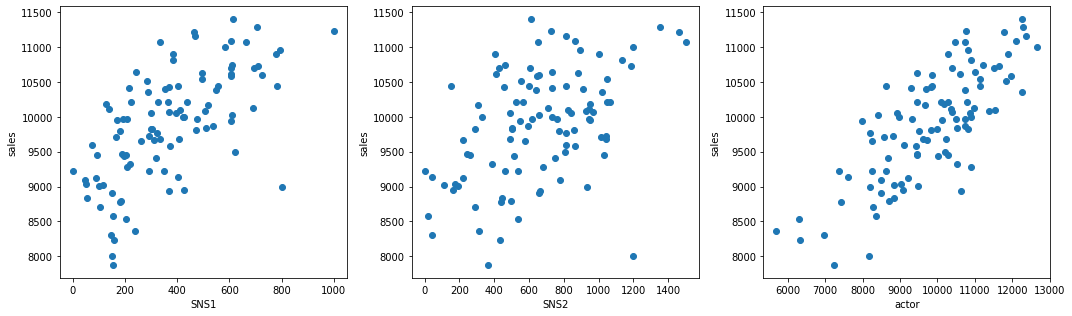

In [5]:
## 散布図を作成して外れ値を確認
# 散布図を3つ横に並べる設定 : subplots の行
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

# 各散布図の縦軸に使うデータ列の名称をリストで準備
columns = ['SNS1', 'SNS2', 'actor']

# forループでリストの各列の散布図を作成
for i in range(len(columns)):
    ax[i].set_xlabel(columns[i])  # 横軸のラベルを設定
    ax[i].set_ylabel('sales')     # 縦軸のラベルを設定
    ax[i].scatter(df2[columns[i]], df2['sales']) # 散布図を作成
plt.tight_layout()  # ラベルの重なりを避けるためのサイズ調整を実施
plt.show()  # グラフを表示

In [6]:
## 外れ値を含む行を削除
# SNS1-sales の右下の点のインデックスを取得
hazure_SNS1_index = df2[(df2['SNS1'] > 700) & (df2['sales'] < 9500)].index.to_list()
print('SNS1-sales outlier', hazure_SNS1_index, '\n', df2.loc[hazure_SNS1_index], '\n')

# SNS2-sales の右下の点のインデックスを取得
hazure_SNS2_index = df2[(df2['SNS2'] > 1000) & (df2['sales'] < 8500)].index.to_list()
print('SNS2-sales outlier', hazure_SNS2_index, '\n', df2.loc[hazure_SNS2_index], '\n')

# 上記の点の行をデータフレームから除去 (list+list でリストを結合)
df3 = df2.drop(hazure_SNS1_index + hazure_SNS2_index, axis=0)
print('date frame shape', df3.shape)

SNS1-sales outlier [50] 
     cinema_id   SNS1  SNS2        actor  original  sales
50       1827  800.0   934  8206.568734         0   9000 

SNS2-sales outlier [30] 
     cinema_id   SNS1  SNS2        actor  original  sales
30       1855  149.0  1200  8173.096892         0   8000 

date frame shape (98, 6)


In [7]:
## 学習・検証用にデータを分割
# データフレームの SNS1,SNS2,actor,originalを入力データとして変数xに代入、salesを正解ラベルとして変数yに代入
x = df3[['SNS1', 'SNS2', 'actor', 'original']]
y = df3['sales']

# データを学習用と検証用に分割 (test_sizeで検証データの比率を指定(0.0-1.0の間), random_stateは乱数シード)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
print(len(x_train), len(x_test), len(y_train), len(y_test)) # それぞれのデータ数を確認

73 25 73 25


In [8]:
# 回帰モデルを作成
model = LinearRegression()

# 回帰モデルを学習用データで学習
model.fit(x_train, y_train)

LinearRegression()

In [9]:
# ダミーデータを用意し、その予測で作成したモデルの動作を確認
x_dummy = pd.DataFrame([[200, 400, 9000, 1]], 
                       columns=['SNS1','SNS2','actor','original'])
model.predict(x_dummy)

array([9433.34138901])

In [10]:
## 検証用データを利用してモデルを評価
# 学習したモデルを使い、検証用データの入力データから最終興行収入を予測
pred = model.predict(x_test)

# 平均絶対誤差、平均二乗誤差、決定係数を計算
print('平均絶対誤差', mean_absolute_error(y_pred=pred, y_true=y_test))
print('平均二乗誤差', mean_squared_error(y_pred=pred, y_true=y_test))
print('決定係数', model.score(x_test, y_test))
print('(参考) 学習データに対する決定係数', model.score(x_train, y_train))

平均絶対誤差 253.30711568503023
平均二乗誤差 119320.43516577514
決定係数 0.7831461734021443
(参考) 学習データに対する決定係数 0.7866517579860794


In [11]:
## 作成したモデルを確認
# モデルの式を確認
print(model.coef_) # モデルの係数を表示
print(model.intercept_) # モデルの切片を表示

[  1.33936552   0.58445685   0.26305028 204.55220007]
6359.6808313122965


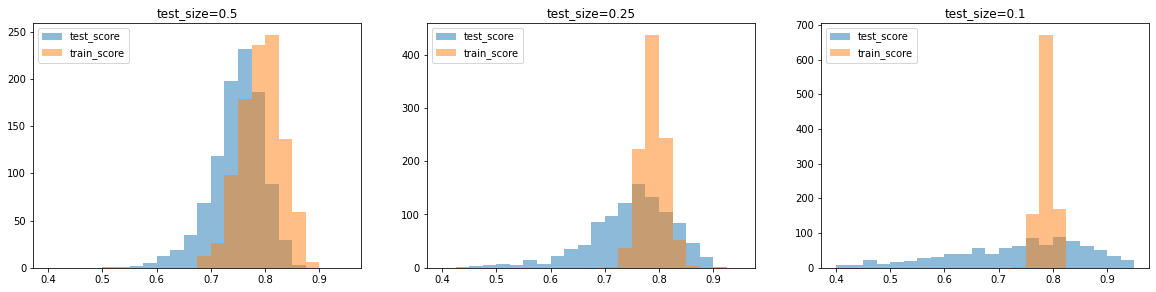

In [18]:
# スライド「データ分割のモデルへの影響」のグラフを作成するためのプログラム
# 散布図を3つ横に並べる設定 : subplots の行
fig, ax = plt.subplots(1, 3, figsize=(20, 4.5))
size = [0.5, 0.25, 0.1]
for i in range(len(size)):
    mae = []
    mse = []
    test_score = []
    train_score = []
    for _rand_seed in range(1000):
        # データを学習用と検証用に分割 
        # (test_sizeで検証データの比率を指定(0.0-1.0の間), random_stateは乱数シード)
        x_train, x_test, y_train, y_test = \
            train_test_split(x, y, test_size=size[i], random_state=_rand_seed)

        model = LinearRegression()    # 回帰モデルを作成
        model.fit(x_train, y_train)    # 回帰モデルを学習用データで学習

        test_score.append(model.score(x_test, y_test)) # 検証用データに対する決定係数
        train_score.append(model.score(x_train, y_train)) # 学習用データに対する決定係数

    # 各決定係数をヒストグラムに表示 (ビンの幅・数を揃えて、透過色で重ね合わせて表示)
    ax[i].set_title(f'test_size={size[i]}')
    ax[i].hist(test_score, alpha=0.5, label='test_score', range=(0.40, 0.95), bins=22)
    ax[i].hist(train_score, alpha=0.5, label='train_score', range=(0.40, 0.95), bins=22)
    ax[i].legend(loc='upper left')
plt.show()